# PROJETO 3 
## André Annunziato, Bruno Tricate e Vitor Carreta

### O intuito do projeto é verificar se há e qual é a relação entre o potencial de um jogador, sua atual classificação e seu valor de mercado no FIFA 18. Para isso, fizemos uma regressão linear múltipla.

In [24]:
# Importando todas as bibliotecas a serem usadas
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import *
import scipy.stats as stats

#Referencia: http://connor-johnson.com/2014/02/18/linear-regression-with-python/

In [2]:
# Lendo os datasets e filtrando as colunas
dados = pd.read_csv('PlayerPersonalData.csv')
dados = dados.drop('Photo', axis=1)
dados = dados.drop('Unnamed: 0', axis=1)
dados = dados.drop('Unnamed: 0.1', axis=1)
dados = dados.drop('Flag', axis=1)
dados = dados.drop('Club Logo', axis=1)
dados = dados.drop('Wage', axis=1)
dados = dados.drop('Special', axis=1)
data = dados[pd.notnull(dados.Value) & pd.notnull(dados.Overall) & pd.notnull(dados.Potential)]

In [27]:
dados.columns

Index(['ID', 'Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club',
       'Value'],
      dtype='object')

#### Para podermos manusear os valores, precisamos transformá-los de strings para números.

In [3]:
Vm = []
Vk = []
V = []
for i in data.Value:
    if "M" in i:
        x = i.replace("€","")
        x = x.replace("M","")
        x = float(x)
        V.append(x*1000)
        

    elif "K" in i:
        x = i.replace("€","")
        x = x.replace("K","")  
        x = float(x)
        V.append(x)
    else:
        V.append(0)

Valor = pd.Series(V)
data["Valor"] = Valor

### Em seguida, fizemos a correlação entre os três atributos anteriormente ditos.

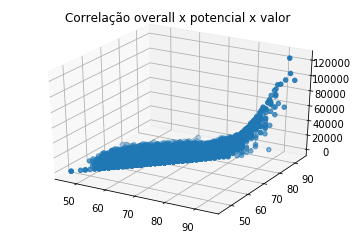

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')

ax.scatter(data.Overall,data.Potential,data.Valor)
plt.title("Correlação overall x potencial x valor")
plt.show()

### Porém, percebemos que a relação era aproximadamente exponencial, portanto, utilizamos o logaritmo do Valor para obtermos a relação linear.

In [5]:
Vlog = []
for i in V:
    if i>0:
        Vlog.append(log(i))
    else:
        Vlog.append(i)

Valor_log = pd.Series(Vlog)
data["Valorlog"] = Valor_log
data = data[pd.notnull(data["Valorlog"])]

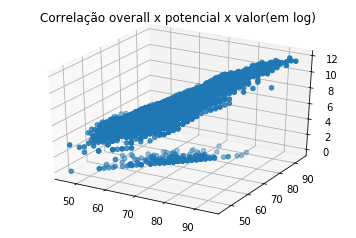

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')

ax.scatter(data.Overall,data.Potential,data.Valorlog)
plt.title("Correlação overall x potencial x valor(em log)")
plt.show()

### Agora, utilizamos a biblioteca statsmodels para obtermos os valores da regressão linear.

In [7]:
y = data.Valorlog
x = np.column_stack((data.Overall,data.Potential))
x = sm.add_constant(x, prepend=True)
res = sm.OLS(y,x).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Valorlog   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                 2.106e+04
Date:                Tue, 21 Nov 2017   Prob (F-statistic):               0.00
Time:                        13:54:06   Log-Likelihood:                -23263.
No. Observations:               17981   AIC:                         4.653e+04
Df Residuals:                   17978   BIC:                         4.655e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.2644      0.078   -105.627      0.000      -8.418      -8.111
x1             0.1385      0.001    107.353      0.000       0.136       0.141
x2             0.0802      0.001     54.296      0.000       0.077       0.083
==============================================================================
Omnibus:                    21736.589   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2131299.720
Skew:                          -6.708   Prob(JB):                         0.00
Kurtosis:                      54.621   Cond. No.                     1.16e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Como pode ser observado, o valor de determinação entre as três variáveis é alto (R-squared = 70.1%), portanto, o cálculo do valor pode ser bem aproximado por uma relação entre classificação e potencial.

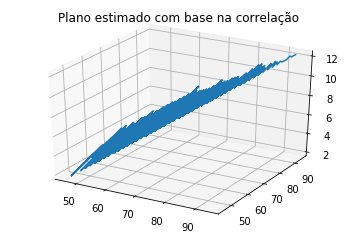

In [8]:
x1 = 0.1385
x2 = 0.0802
const = -8.2644


y = data.Overall*x1 + data.Potential*x2 + const

fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.plot_wireframe(data.Overall,data.Potential,y)
plt.title("Plano estimado com base na correlação")
plt.show()

### Para efeito de confirmação, calculamos o resíduo da nossa regressão, ou seja, a diferença entre os valores reais e os estimados pelo plano.

In [20]:
residuo = data.Valorlog - y

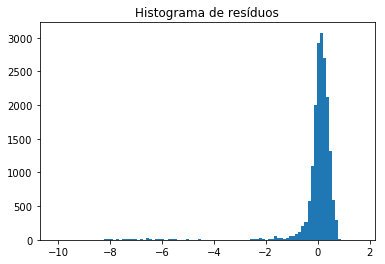

In [21]:
plt.hist(residuo,bins = 100)
plt.title("Histograma de resíduos")
plt.show()

In [25]:
from scipy import stats
stats.probplot(residuo, dist="norm")

((array([-3.95325174, -3.73577467, -3.61671592, ...,  3.61671592,
          3.73577467,  3.95325174]),
  array([-10.1283    ,  -9.8877    ,  -9.669     , ...,   1.09554456,
           1.15382301,   1.60539738])),
 (0.55171324150750067, 0.00027747432441375285, 0.62516842186366506))

### O histograma de densidade acima nos mostra que há uma frequência muito maior de resíduos muito pequenos, menores que 10 milhões de euros. Portanto, jogadores supervalorizados, podem dar uma diferença muito grande.

### Exemplo:

#### Vamos calcular o valor de mercado do jogador brasileiro Gabriel Jesus:

In [11]:
data[data.Name == "Gabriel Jesus"]

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Valor,Valorlog
299,230666,Gabriel Jesus,20,Brazil,81,92,Manchester City,€31M,31000.0,10.341742


In [12]:
valor = 81*x1 + 92*x2 + const

In [13]:
exp(valor)

30714.803006968228

#### Obs.: Foi feito o exp() do valor porque no início utilizamos o log do valor real para a regressão. Portanto, para efeito de comparação, voltamos o resultado ao seu valor padrão.

#### Como podemos ver, o valor calculado deu bem próximo do valor real, portanto nossa regressão é válida.

### Tente você mesmo!

In [34]:
jogador = input("Digite o nome de um Jogador (digite como aparece no jogo).\nPara ver alguns exemplos, digite 'ajuda': ")

if jogador == "ajuda":
    print(data.Name.head())
else:
    nome = data[data.Name == jogador].head(1)
    valor = nome.Overall*x1 + nome.Potential*x2 + const
    print("Valor calculado: {0:.2f} (em milhares de euros)".format(exp(valor)))
    
    print("Valor real: {0} (em milhares de euros)".format(float(data[data.Name == jogador].head(1).Valor)))

Digite o nome de um Jogador (digite como aparece no jogo).
Para ver alguns exemplos, digite 'ajuda': Casemiro
Valor calculado: 42019.96 (em milhares de euros)
Valor real: 42000.0 (em milhares de euros)


### Conclusão
    O dataset do Fifa 18 contém uma série de informações para todos os jogadores disponíveis dentro do jogo. Entre essas informações, podemos citar dados referentes a habilidade do jogador nas diferentes áreas do jogo, como ataque, defesa, drible, poder, entre outros dados de habilidade. Porém, dentre os dados apresentados, três acabam chamando mais atenção do que os demais, Overall, que seria basicamente uma nota dada ao jogador com base em todos os dados de habilidade, Potencial, que se trata de uma “previsão” que o jogo cria considerando a capacidade do jogador de desenvolver seus atributos e alcançar um valor de Overall maior do que o inicial, e o Valor de mercado, que se trata, basicamente, do valor de venda do jogador no jogo. 
    Dentre todos os dados fornecidos, o de Valor de Mercado é o mais “intrigante”, visto que o jogo não explicita a maneira com que este valor é definido, por isso, decidimos tratar como pergunta como o jogo define tal valor.
    Consideramos de início testar se as variáveis Overall, Potencial e Value (Valor de mercado) apresentavam uma correlação, para tentar encontrar a forma que o Value era definido. Visto que a relação entre os valores se mostrava aproximadamente exponencial, utilizamos o logaritmo dos valores para obter a relação linear.  Como resultado da regressão, obtivemos um valor de “R-squared” ou R², que se trata basicamente de quão bem o modelo se encaixa nos dados analisados, onde temos um valor alto de determinação do modelo se encaixar nos dados analisados, de 70,1%. Além disso, obtivemos valores baixos de p-value, ou seja, é baixa a probabilidade de aceitarmos a hipótese nula, o que significa que nosso modelo aparenta estar de acordo com os dados analisados.
    Para confirmar o que obtivemos no último passo, analisamos os resíduos da nossa regressão, que trata da diferença entre os valores reais dados pelo dataset e os valores estimados pelo plano. O resultado se aproximou de uma normal, mostrando novamente que nosso modelo se encaixa no que foi previsto. Nesta análise dos resíduos, é possível observar também, que, pela existência de uma frequência grande de resíduos pequenos, jogadores “supervalorizados” apresentariam uma diferença grande entre o valor obtido pelo modelo e o valor real.
    Após estas análises, testamos com um jogador, Gabriel Jesus, e o valor obtido pelo modelo se aproximou muito do valor real, demonstrando que nosso modelo é válido, visto que ele é um jogador considerado uma promessa dentro do jogo com base em seu Potencial, de forma que a maior parte dos jogadores nesta mesma categoria apresentam grande proximidade entre o valor calculado e o valor real. Além disso, adicionamos uma opção para facilitar ao usuário a utilização do programa, onde existe um campo para inserção do nome de um jogador do jogo Fifa 18, que retorna o valor obtido pelo modelo e o real, permitindo a comparação.
    No mais, o objetivo de se obter um modelo que demonstrasse o cálculo por trás do Value ou Valor de Mercado dentro do jogo foi concluído. Foi feito o uso do logaritmo dos dados para aperfeiçoar o resultado, com base na distribuição da relação linear. Para melhorar o modelo, teríamos que encontrar outros dados presentes no dataset que também apresentassem uma boa correlação com os já utilizados, para possivelmente obter melhores resultados no que se dizem os jogadores “supervalorizados”, que possuem um cálculo diferente para o valor de mercado.  
